In [1]:
!nvidia-smi

Sat Aug  3 10:17:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                      On | 00000000:01:00.0 Off |                    0 |
|  0%   84C    P0              184W / 300W|  40334MiB / 46068MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
original_data_path = '../data/mp_forces/data.json' # path to raw data
calculator_path = '../configs/calculator/config_morse.yml' # path to calculator config
rank = 5 # device Nr.
batch_size = 16
save_dir = '../data/mp_0.15_0.75_5_aug' # path to save augmented data
perturb_strength = [0.15, 0.3, 0.45, 0.6, 0.75] # perturbation strength
task = "simulation" # optimization doesn't need labels
n_round_augmentation = len(perturb_strength)
calculated_properties = ('energy', 'forces', 'stress')

In [3]:
import json

with open(original_data_path, 'r') as f:
    data = json.load(f)
    
len(data)

187687

In [4]:
import numpy as np

structures = [{key: np.array(val) if isinstance(val, list) else val for key, val in dt.items()} for dt in data]

In [5]:
orig_forces = np.concatenate([structure['forces'] for structure in structures])
force_magnitude = np.linalg.norm(orig_forces, axis=1)
force_magnitude.shape

(5625046,)

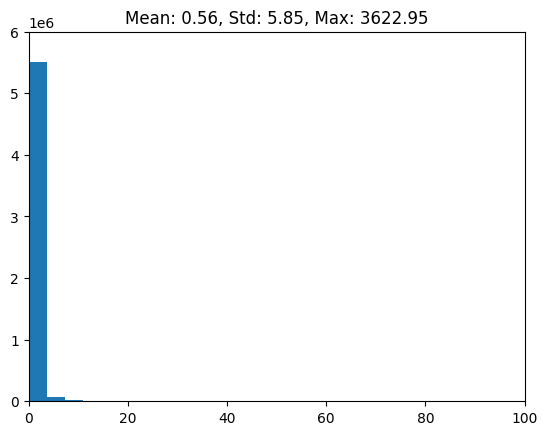

In [6]:
import matplotlib.pyplot as plt

plt.hist(force_magnitude, bins=1000)
plt.title(f"Mean: {np.mean(force_magnitude):.2f}, Std: {np.std(force_magnitude):.2f}, Max: {np.max(force_magnitude):.2f}")
plt.xlim(left=0, right=100)
plt.ylim(bottom=0, top=6*10e5)
plt.show();

In [7]:
import numpy as np

def perturb_positions(pos, distance):
    random_vectors = np.random.randn(pos.shape[0], 3)
    random_vectors /= np.linalg.norm(random_vectors, axis=1, keepdims=True)
    perturbation_distances = np.full((pos.shape[0],), distance)
    return pos + perturbation_distances.reshape(-1, 1) * random_vectors

In [8]:
from itertools import chain

augmented_structure_list = [list() for _ in range(n_round_augmentation)]

for i in range(n_round_augmentation):
    for s in structures:
        aug = s.copy()
        aug['positions'] = perturb_positions(s['positions'], perturb_strength[i])
        augmented_structure_list[i].append(aug)
        
augmented_structures = list(chain.from_iterable(augmented_structure_list))
len(augmented_structures)

938435

In [9]:
# For optimization
structure_to_write = []
if task == 'optim':
    for s in augmented_structures:
        structure_to_write.append({
            'structure_id': s['structure_id'],
            'positions': s['positions'].tolist(),
            'cell': s['cell'].tolist(),
            'atomic_numbers': s['atomic_numbers'].tolist()
        })
    json.dump(structure_to_write, open(f'{save_dir}/data.json', 'w'))
    

In [10]:
from typing import List
from ase import Atoms

if task != "optim":
    atoms_list: List[Atoms] = [
        Atoms(
            symbols=s['atomic_numbers'],
            positions=s['positions'],
            cell=s['cell']
        )
        for s in augmented_structures
    ]

In [11]:
from matdeeplearn.common.ase_utils import MDLCalculator

if task != "optim":
    calc = MDLCalculator(calculator_path, rank=rank)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/nethome/qzheng75/miniconda3/envs/md_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/nethome/qzheng75/miniconda3/envs/md_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/nethome/qzheng75/miniconda3/envs/md_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/nethome/qzheng75/miniconda3/envs/md_env/lib/python3.9/site-packages/traitlets/config/appl

ModuleNotFoundError: No module named 'pymatgen'

In [ ]:
import torch
from torch_geometric.loader import DataLoader

if task != "optim":
    data_list = [
        calc.atoms_to_data_object(atoms) for atoms in atoms_list
    ]

    results = {prop: [] for prop in calculated_properties}
    results.update(
        {
            'structure_id': [s['structure_id'] for s in augmented_structures],
            'positions': [s['positions'] for s in augmented_structures],
            'cell': [s['cell'] for s in augmented_structures],
            'atomic_numbers': [s['atomic_numbers'] for s in augmented_structures],
        }
    )

In [ ]:
from tqdm import tqdm

if task != "optim":
    loader = DataLoader(data_list, batch_size=batch_size)
    loader_iter = iter(loader)

    for idx, batch in tqdm(enumerate(loader_iter), total=len(loader_iter)):
        batch = batch.to(f'cuda:{rank}')
        
        out_list = []
        for model in calc.models:   
            model.eval()
            out_list.append(model(batch))

        energy = torch.stack([entry["output"] for entry in out_list]).mean(dim=0).detach().cpu().numpy().flatten().tolist()
        forces = torch.stack([entry["pos_grad"] for entry in out_list]).mean(dim=0)
        stresses = torch.stack([entry["cell_grad"] for entry in out_list]).mean(dim=0)
        
        forces_each_structure = []
        stress_each_structure = []
        
        for i in range(len(batch)):
            split_force = forces[torch.where(batch.batch == i)]
            forces_each_structure.append(split_force.detach().cpu().numpy().tolist())
            stress_each_structure.append(stresses[i].detach().cpu().numpy().tolist())
        
        results['energy'].extend(energy)
        results['forces'].extend(forces_each_structure)
        results['stress'].extend(stress_each_structure)

100%|██████████| 58653/58653 [09:31<00:00, 102.65it/s] 


In [ ]:
import matplotlib.pyplot as plt

if task != "optim":
    for key in results.keys():
        print(key, ':', len(results[key]))
        
    forces_arr = np.concatenate(results['forces'], axis=0)
    force_magnitude = np.linalg.norm(forces_arr, axis=1)
    
    plt.hist(force_magnitude, bins=1000)
    plt.title(f"Mean: {np.mean(force_magnitude):.2f}, Std: {np.std(force_magnitude):.2f}, Max: {np.max(force_magnitude):.2f}")
    plt.xlim(left=0, right=500)
    plt.ylim(bottom=0, top=1.2*10e6)
    plt.show();

energy : 938435
forces : 938435
stress : 938435
structure_id : 938435
positions : 938435
cell : 938435
atomic_numbers : 938435


In [ ]:
import os

if task != "optim":
    os.makedirs(save_dir, exist_ok=True)
    saved_data = [
        {
            'structure_id': results['structure_id'][i],
            'positions': results['positions'][i].tolist(),
            'cell': results['cell'][i].tolist(),
            'atomic_numbers': results['atomic_numbers'][i].tolist(),
            'y': results['energy'][i],
            'energy': results['energy'][i],
            'stress': [results['stress'][i]],
            'forces': results['forces'][i],
        } for i in range(len(results['structure_id']))
    ]

    with open(f'{save_dir}/data.json', 'w') as f:
        json.dump(saved_data, f)
        
    print(f'{len(saved_data)} structures saved')